In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
from bs4 import BeautifulSoup
import json
import numpy as np

In [2]:
with open("/content/drive/MyDrive/Sarcasm-Detector/Sarcasm.json",'r') as input:
  data = json.load(input)

In [3]:
## Use NLTK's Stopword List
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
sarcasm_sentences = []
labels = []
links = []
punctuations = str.maketrans('', '', string.punctuation)
for item in data:
  sentence = item['headline'].lower()
  sentence = sentence.replace(",", " , ").replace(".", " . ").replace("-", " - ").replace("/", " / ")
  sentence = BeautifulSoup(sentence, "html.parser").get_text()

  words = sentence.split()
  filtered_sentence = ""

  for word in words:
    word = word.translate(punctuations)
    if word not in stopwords:
      filtered_sentence += word + " "
  sarcasm_sentences.append(filtered_sentence)
  labels.append(item['is_sarcastic'])
  links.append(item['article_link'])

In [5]:
print(len(sarcasm_sentences))

26709


In [11]:
training_size = 23000
vocab_size = 1000
training_sentences = sarcasm_sentences[0:training_size]
training_labels = labels[0:training_size]
testing_sentences = sarcasm_sentences[training_size:]
testing_labels = labels[training_size:]

In [12]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequence, padding="post")
testing_sequence = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequence, padding="post")

In [13]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels).astype(np.float32).reshape(-1)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels).astype(np.float32).reshape(-1)

In [14]:
model = tf.keras.Sequential([
          tf.keras.layers.Embedding(10000, 16),
          tf.keras.layers.GlobalAveragePooling1D(),
          tf.keras.layers.Dense(24, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )
model.build(input_shape=(None, training_padded.shape[1]))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 27, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,433 (626.69 KB)

 Trainable params: 160,433 (626.69 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels)
                  )

Epoch 1/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7969 - loss: 0.4177 - val_accuracy: 0.6703 - val_loss: 0.8487
Epoch 2/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7979 - loss: 0.4153 - val_accuracy: 0.7053 - val_loss: 0.7228
Epoch 3/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7975 - loss: 0.4096 - val_accuracy: 0.6905 - val_loss: 0.8072
Epoch 4/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7966 - loss: 0.4134 - val_accuracy: 0.6924 - val_loss: 0.7585
Epoch 5/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7934 - loss: 0.4163 - val_accuracy: 0.6530 - val_loss: 0.9276
Epoch 6/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7973 - loss: 0.4119 - val_accuracy: 0.6967 - val_loss: 0.7793
Epoch 7/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7988 - loss: 0.4105 - val_accuracy: 0.6862 - val_loss: 0.7784
Epoch 8/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7951 - loss: 0.4129 - val_accuracy: 0.

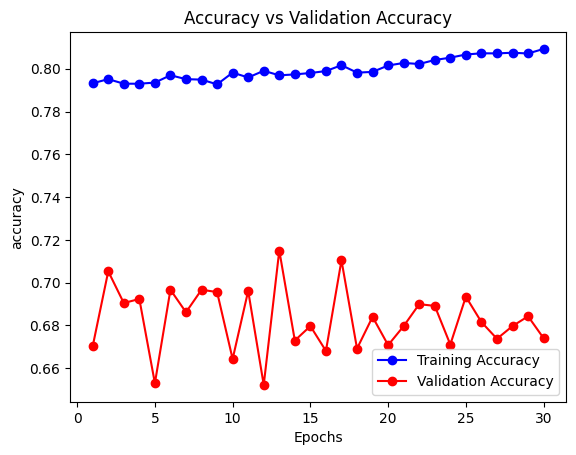

In [36]:
## plotting accuracy vs validation accuracy
import matplotlib.pyplot as plt

def plot_accuracy(history):
  acc = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
  plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
  plt.title("Accuracy vs Validation Accuracy")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')
  plt.show()
plot_accuracy(history)

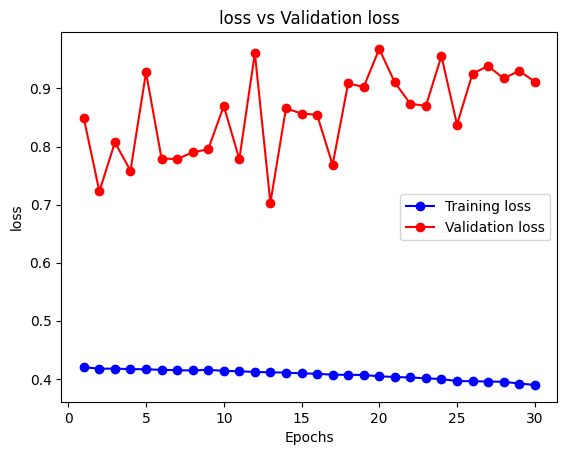

In [37]:
## plotting loss vs validation loss
import matplotlib.pyplot as plt

def plot_accuracy(history):
  acc = history.history['loss']
  val_accuracy = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo-', label='Training loss')
  plt.plot(epochs, val_accuracy, 'ro-', label='Validation loss')
  plt.title("loss vs Validation loss")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('loss')
  plt.show()
plot_accuracy(history)

## Reducing Overfitting in Language Models

In [38]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy']
              )

In [ ]:
history = model.fit(training_padded, training_labels,
                    epochs=100,
                    validation_data=(testing_padded, testing_labels)
                  )

Epoch 1/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8211 - loss: 0.3717 - val_accuracy: 0.6816 - val_loss: 0.9726
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8183 - loss: 0.3795 - val_accuracy: 0.6794 - val_loss: 0.9855
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8187 - loss: 0.3775 - val_accuracy: 0.6773 - val_loss: 0.9962
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8214 - loss: 0.3723 - val_accuracy: 0.6835 - val_loss: 0.9712
Epoch 5/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8180 - loss: 0.3706 - val_accuracy: 0.6783 - val_loss: 0.9995
Epoch 6/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8176 - loss: 0.3751 - val_accuracy: 0.6765 - val_loss: 1.0077
Epoch 7/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8212 - loss: 0.3703 - val_accuracy: 0.6762 - val_loss: 1.0096
Epoch 8/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8205 - loss: 0.3698 - val_accu